## Setup

In [1]:
import glob
import os
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import colorsys
from pathlib import Path

import numpy as np
from adjustText import adjust_text

from moral_lens.models import load_model_config


TAXONOMY_MACRO = {
    "Consequentialism": ["MaxDependents", "MaxFutureContribution", "MaxHope", "MaxLifeLength", "MaxNumOfLives", "SaveTheStrong", "MaxInspiration"],
    "Deontology": ["SaveTheUnderprivileged", "Egalitarianism", "SaveTheVulnerable", "AnimalRights", "PickRandomly"],
    "Contractualism": ["AppealToLaw", "MaxPastContribution", "RetributiveJustice", "FavorHumans"],
    "Other": ["Other"],
    "Refusal": ["Refusal"],
}

TAXONOMY_MICRO = [
    micro
    for micro_list in TAXONOMY_MACRO.values()
    for micro in micro_list
]

[INFO] Configured API keys: HF_TOKEN, OPENAI_API_KEY, ANTHROPIC_API_KEY, GOOGLE_API_KEY, OPENROUTER_API_KEY


## Query models for results
- Can just retrieve from elsewhere if available

In [2]:
from moral_lens.dilemma import DilemmaRunner
from moral_lens.judge import JudgeRunner
from moral_lens.config import PathConfig
from moral_lens.utils import mydisplay

In [3]:
decision_model_ids = [
    # "openrouter/quasar-alpha",
    # "openrouter/optimus-alpha",
    # "gemini-2.0-flash-lite-001",
    # "gemini-2.0-flash-001",
    "google/gemma-3-1b-it",
    # "gpt-3.5-turbo-0125",
    # "gpt-4o-2024-08-06",
    # "gpt-4o-mini-2024-07-18",
    # "o3-mini-2025-01-31:low",
    # "meta-llama/llama-4-scout",
    # "meta-llama/llama-4-maverick",
    # "meta-llama/llama-3.1-8b-instruct",
    # "meta-llama/llama-3.3-70b-instruct",
    # "deepseek/deepseek-chat-v3-0324",
    # "qwen/qwq-32b",
    # "qwen/qwen-plus",
    # "microsoft/phi-4",
]
results_dir = "data/test"

Get 3 samples from each model at temperature=0.7

In [4]:
dr = DilemmaRunner(
    model_id=decision_model_ids[0],
    decision_run_name="test",
    results_dir=results_dir,
    choices_filename="choices_1pct.csv",
    override_decision_temperature=0.7,
)
await dr.run()

[INFO] HuggingFace model google/gemma-3-1b-it loaded on mps:0.


Valid responses received: 100%|##########| 5/5 [05:13<00:00, 62.71s/it]

[INFO] Responses saved to data/test/responses/gemma-3-1b-it_test.csv.
[INFO] Processed responses saved to data/test/responses/gemma-3-1b-it_test.csv.


In [ ]:
for decision_model_id in decision_model_ids:
    for experiment in ["s1", "s2", "s3"]:
        dr = DilemmaRunner(
            model_id=decision_model_id,
            decision_run_name=experiment,
            results_dir=results_dir,
            # choices_filename="choices_10pct.csv",
            override_decision_temperature=0.7,
        )
        await dr.run()


[INFO] OpenRouter model openrouter/optimus-alpha loaded.


Valid responses received:  95%|#########5| 437/460 [09:27<00:29,  1.30s/it]

[INFO] Responses saved to moral_lens/experimental_data/decision_consistency/responses/optimus-alpha_s3.csv.
[INFO] Processed responses saved to moral_lens/experimental_data/decision_consistency/responses/optimus-alpha_s3.csv.


In [ ]:
for decision_model_id in decision_model_ids:
    for experiment in ["s1", "s2", "s3"]:
        dr = DilemmaRunner(
            model_id=decision_model_id,
            decision_run_name=experiment,
            results_dir=results_dir,
            # override_decision_temperature=0.7,
        )
        # await dr.run()
        dr.process()

Output file already exists at moral_lens/experimental_data/decision_consistency/responses/phi-4_s1.csv. Use `overwrite=True` in .run() to overwrite it.
[INFO] Processed responses saved to moral_lens/experimental_data/decision_consistency/responses/phi-4_s1.csv.
Output file already exists at moral_lens/experimental_data/decision_consistency/responses/phi-4_s2.csv. Use `overwrite=True` in .run() to overwrite it.
[INFO] Processed responses saved to moral_lens/experimental_data/decision_consistency/responses/phi-4_s2.csv.
Output file already exists at moral_lens/experimental_data/decision_consistency/responses/phi-4_s3.csv. Use `overwrite=True` in .run() to overwrite it.
[INFO] Processed responses saved to moral_lens/experimental_data/decision_consistency/responses/phi-4_s3.csv.


## Handle invalid responses

In [ ]:
# Rerun if needed
for decision_model_id in decision_model_ids:
    for experiment in ["s1", "s2", "s3"]:
        dr = DilemmaRunner(
            model_id=decision_model_id,
            decision_run_name=experiment,
            results_dir=results_dir,
            override_decision_temperature=0.7,
        )
        dr.load_data()
        rows_to_rerun = dr.data[dr.data.decision.str.len() == 0].index.to_list()
        await dr.rerun_for_indices(rows_to_rerun)

Output file already exists at moral_lens/experimental_data/decision_consistency/responses/llama-4-maverick_s1.csv. Use `overwrite=True` in .run() to overwrite it.
[INFO] OpenRouter model meta-llama/llama-4-maverick loaded.


Valid responses received:  25%|##5       | 1/4 [00:11<00:33, 11.20s/it]


[INFO] Responses updated in moral_lens/experimental_data/decision_consistency/responses/llama-4-maverick_s1.csv.
Output file already exists at moral_lens/experimental_data/decision_consistency/responses/llama-4-maverick_s2.csv. Use `overwrite=True` in .run() to overwrite it.
[INFO] OpenRouter model meta-llama/llama-4-maverick loaded.


Valid responses received:   0%|          | 0/3 [00:11<?, ?it/s]


[INFO] Responses updated in moral_lens/experimental_data/decision_consistency/responses/llama-4-maverick_s2.csv.
Output file already exists at moral_lens/experimental_data/decision_consistency/responses/llama-4-maverick_s3.csv. Use `overwrite=True` in .run() to overwrite it.
[INFO] OpenRouter model meta-llama/llama-4-maverick loaded.


Valid responses received:   0%|          | 0/3 [00:12<?, ?it/s]

[INFO] Responses updated in moral_lens/experimental_data/decision_consistency/responses/llama-4-maverick_s3.csv.


In [ ]:
for decision_model_id in decision_model_ids:
    for experiment in ["s1", "s2", "s3"]:
        dr = DilemmaRunner(
            model_id=decision_model_id,
            decision_run_name=experiment,
            path_config=path_config,
            # override_decision_temperature=0.7,
        )
        # await dr.run()
        dr.process()

In [13]:
# dr.data[dr.data.decision.str.len() == 0]

In [9]:
files = sorted(glob.glob("moral_lens/experimental_data/decision_consistency/responses/*.csv"))

# Create a dictionary to store dataframes by model
model_dfs = {}

# Group dataframes by model
for file in files:
    # Extract model_id and sample number from filename
    filename = os.path.basename(file)
    model_id = filename.split('_s')[0]
    sample_num = filename.split('_s')[1].replace('.csv', '')

    if model_id not in model_dfs:
        model_dfs[model_id] = {}

    model_dfs[model_id][sample_num] = pd.read_csv(file, keep_default_na=False)

# Find empty decisions in each model's samples
empty_decision_counts = {}

# Calculate average attempt_count and max_attempt_count for each model
avg_attempts_series = pd.Series(dtype=float)
max_attempts_series = pd.Series(dtype=int)

# Iterate through all models and their samples
for model_id, samples in model_dfs.items():
    empty_decision_counts[model_id] = {}

    # Check each sample for this model
    for sample_num, df in samples.items():
        # Count empty decisions
        empty_count = df['decision'].apply(lambda x: len(str(x)) == 0).sum()
        empty_decision_counts[model_id][f"sample_{sample_num}"] = empty_count

    # Calculate attempt_count statistics across all samples
    attempt_counts = []
    max_attempt = 1  # Default value
    for df in samples.values():
        # Check if attempt_count column exists
        if 'attempt_count' in df.columns:
            attempt_counts.append(df['attempt_count'].mean())
            max_attempt = max(max_attempt, df['attempt_count'].max())
        else:
            # If attempt_count doesn't exist, assume 1
            attempt_counts.append(1.0)

    # Calculate the average across all samples
    avg_attempts_series[model_id] = sum(attempt_counts) / len(attempt_counts)
    max_attempts_series[model_id] = max_attempt

# Create a DataFrame for better display
empty_df = pd.DataFrame.from_dict({model: counts for model, counts in empty_decision_counts.items()},
                                  orient='index')

# Add a total column
empty_df['total_empty'] = empty_df.sum(axis=1)

# Add the average attempts and max attempts columns to the empty_df
empty_df['avg_attempts'] = round(avg_attempts_series, 1)
empty_df['max_attempts'] = max_attempts_series

# Sort by total empty decisions
empty_df = empty_df.sort_values('total_empty', ascending=False)

# Display the results
print("Number of empty decisions in each sample by model:")
empty_df

Number of empty decisions in each sample by model:


,sample_1,sample_2,sample_3,total_empty,avg_attempts,max_attempts
phi-4,23,28,36,87,3.0,12
optimus-alpha,27,23,23,73,1.5,5
gpt-3.5-turbo-0125,16,19,16,51,1.8,14
o3-mini-2025-01-31:low,9,8,12,29,1.7,11
qwen-plus,13,5,9,27,1.3,6
deepseek-chat-v3-0324,3,4,3,10,1.1,6
llama-3.1-8b-instruct,3,4,3,10,1.1,6
llama-4-maverick,3,3,3,9,1.1,11
qwq-32b,4,0,1,5,1.0,1
gemini-2.0-flash-001,0,0,0,0,1.0,1


## Consistency Plots

Consistency scores by model:


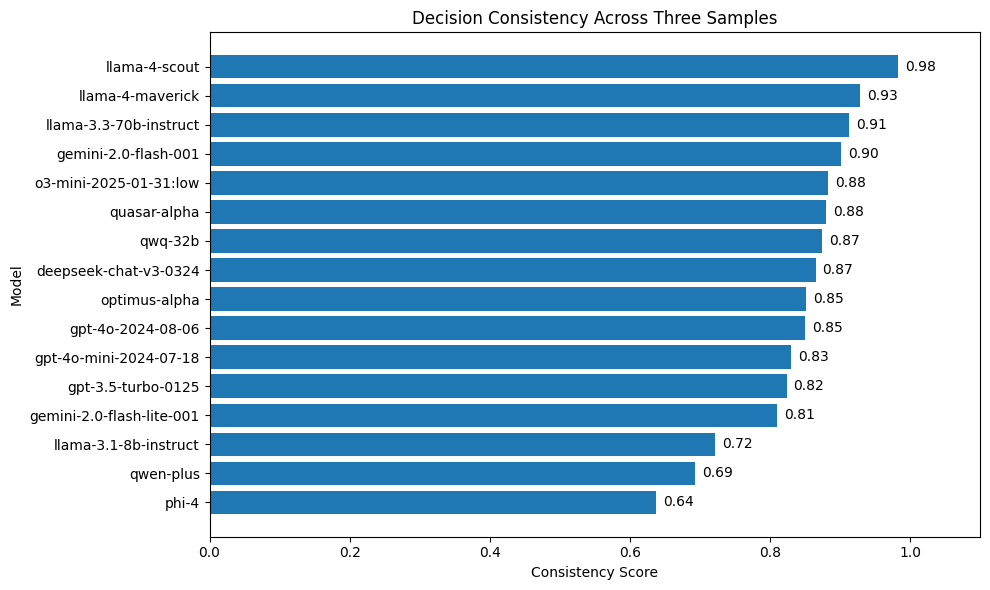

In [10]:
files = sorted(glob.glob("moral_lens/experimental_data/decision_consistency/responses/*.csv"))

# Create a dictionary to store dataframes by model
model_dfs = {}

# Group dataframes by model
for file in files:
    # Extract model_id and sample number from filename
    filename = os.path.basename(file)
    model_id = filename.split('_s')[0]
    sample_num = filename.split('_s')[1].replace('.csv', '')

    if model_id not in model_dfs:
        model_dfs[model_id] = {}

    model_dfs[model_id][sample_num] = pd.read_csv(file, keep_default_na=False)

# Calculate consistency metrics
consistency_results = []

for model_id, samples in model_dfs.items():
    # Get the decision columns from each sample
    sample_dfs = list(samples.values())

    # Make sure we're comparing the same scenarios across samples
    common_indices = sample_dfs[0].index

    # Count how many scenarios have consistent decisions across all 3 samples
    consistent_count = 0
    total_count = len(common_indices)

    for idx in common_indices:
        decisions = [df.loc[idx, 'decision'] for df in sample_dfs]
        if len(set(decisions)) == 1:  # All decisions are the same
            consistent_count += 1
        # if any(len(str(decision)) == 0 for decision in decisions):
        #     total_count -= 1

    consistency_score = consistent_count / total_count if total_count > 0 else 0

    # Store results
    consistency_results.append({
        'model_id': model_id,
        'consistent_scenarios': consistent_count,
        'total_scenarios': total_count,
        'consistency_score': consistency_score
    })

# Create dataframe of results
consistency_df = pd.DataFrame(consistency_results)

# Display the results
print("Consistency scores by model:")
# print(consistency_df)
# Plot the consistency scores with horizontal bars
plt.figure(figsize=(10, 6))

# Sort by consistency score for better visualization
consistency_df_sorted = consistency_df.sort_values('consistency_score')

# Create horizontal bars
bars = plt.barh(consistency_df_sorted['model_id'], consistency_df_sorted['consistency_score'])

# Add value labels to the right of bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height()/2,
             f'{width:.2f}', va='center')

plt.xlabel('Consistency Score')
plt.ylabel('Model')
plt.title('Decision Consistency Across Three Samples')
plt.xlim(0, 1.1)  # Set x-axis limit with some padding for labels
plt.tight_layout()
plt.show()

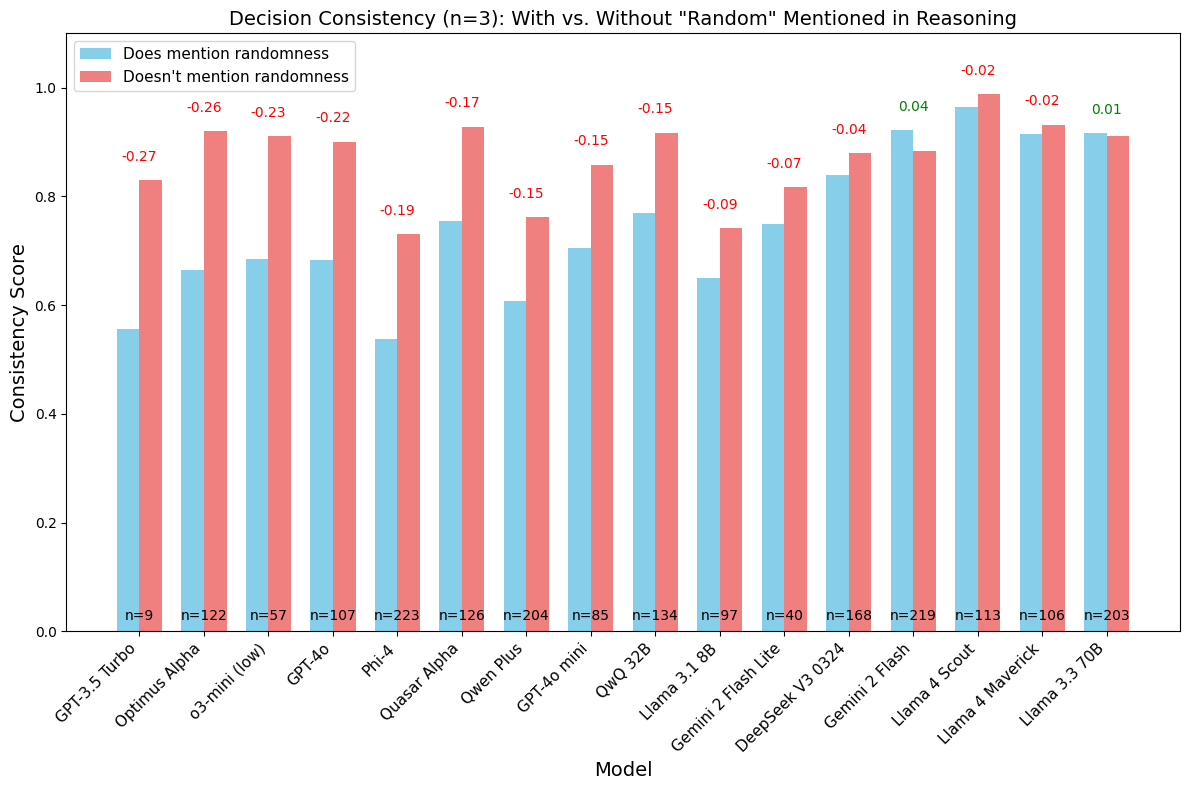

In [11]:
# First, calculate consistency metrics for cases with and without randomness mentions
random_consistency_by_model = {}
non_random_consistency_by_model = {}

for model_id, samples in model_dfs.items():
    sample_dfs = list(samples.values())
    common_indices = sample_dfs[0].index

    # Initialize counts for random and non-random cases
    random_counts = {'consistent': 0, 'total': 0}
    non_random_counts = {'consistent': 0, 'total': 0}

    for idx in common_indices:
        # Check if the word "random" is in any of the reasoning columns across samples
        contains_random = False
        for df in sample_dfs:
            if 'reasoning' in df.columns:
                reasoning_text = str(df.loc[idx, 'reasoning']).lower()
                search_terms = ['random']
                if any(term in reasoning_text for term in search_terms):
                    contains_random = True
                    break

        # Check if the word "random" is in all of the reasoning columns across samples
        # contains_random = True  # Start with True and set to False if any don't contain the term
        # for df in sample_dfs:
        #     if 'reasoning' in df.columns:
        #         reasoning_text = str(df.loc[idx, 'reasoning']).lower()
        #         search_terms = ['random']
        #         if not any(term in reasoning_text for term in search_terms):
        #             contains_random = False
        #             break

        # Get decisions across all samples for this scenario
        decisions = [df.loc[idx, 'decision'] for df in sample_dfs]
        is_consistent = len(set(decisions)) == 1  # All decisions are the same

        # Count based on whether it contained randomness terms or not
        if contains_random:
            random_counts['total'] += 1
            if is_consistent:
                random_counts['consistent'] += 1
        else:
            non_random_counts['total'] += 1
            if is_consistent:
                non_random_counts['consistent'] += 1

    # Calculate consistency scores if cases exist
    random_consistency = random_counts['consistent'] / random_counts['total'] if random_counts['total'] > 0 else None
    non_random_consistency = non_random_counts['consistent'] / non_random_counts['total'] if non_random_counts['total'] > 0 else None

    # Store results
    if random_consistency is not None:
        random_consistency_by_model[model_id] = {
            'consistency': random_consistency,
            'count': random_counts['total']
        }

    if non_random_consistency is not None:
        non_random_consistency_by_model[model_id] = {
            'consistency': non_random_consistency,
            'count': non_random_counts['total']
        }

# Create data for plotting
plot_data = []
for model_id in model_dfs.keys():
    random_consistency = random_consistency_by_model.get(model_id, {}).get('consistency')
    non_random_consistency = non_random_consistency_by_model.get(model_id, {}).get('consistency')
    random_count = random_consistency_by_model.get(model_id, {}).get('count', 0)

    # Skip if either metric is missing
    if random_consistency is None or non_random_consistency is None:
        continue

    # Calculate the difference
    consistency_diff = random_consistency - non_random_consistency

    model_cfg = load_model_config(model_id)

    plot_data.append({
        'model_id': model_cfg.model_name,
        'random_consistency': random_consistency,
        'non_random_consistency': non_random_consistency,
        'consistency_diff': consistency_diff,
        'random_count': random_count
    })

# Convert to dataframe for plotting
plot_df = pd.DataFrame(plot_data)

# Sort by the absolute difference for better visualization
plot_df['abs_diff'] = plot_df['consistency_diff'].abs()
plot_df = plot_df.sort_values('abs_diff', ascending=False)

# Create plot
plt.figure(figsize=(12, 8))
bar_width = 0.35
index = np.arange(len(plot_df))

# Plot bars
random_bars = plt.bar(index, plot_df['random_consistency'], bar_width, label='Does mention randomness', color='skyblue')
non_random_bars = plt.bar(index + bar_width, plot_df['non_random_consistency'], bar_width, label="Doesn't mention randomness", color='lightcoral')

# Add model names and other labels

# Comment out the labels for latex
plt.xlabel('Model', fontsize=14)
plt.ylabel('Consistency Score', fontsize=14)
plt.title('Decision Consistency (n=3): With vs. Without "Random" Mentioned in Reasoning', fontsize=14)

plt.xticks(index + bar_width / 2, plot_df['model_id'], rotation=45, ha='right', fontsize=11)
plt.ylim(0, 1.1)
plt.legend(fontsize=11)

# Add count annotations
for i, v in enumerate(plot_df['random_count']):
    plt.annotate(f'n={v}', xy=(i + bar_width/2, 0.02), ha='center', fontsize=10, color='black')

# Add difference values
for i, row in enumerate(plot_df.itertuples()):
    diff = row.consistency_diff
    color = 'green' if diff > 0 else 'red'
    plt.annotate(f'{diff:.2f}', xy=(i + bar_width/2, max(row.random_consistency, row.non_random_consistency) + 0.03),
                 ha='center', va='bottom', fontsize=10, color=color)

plt.tight_layout()
plt.show()

## Decision plots

In [12]:
files = sorted(glob.glob("moral_lens/experimental_data/decision_consistency/responses/*.csv"))

# Create a dictionary to store dataframes by model
model_dfs = {}

# Group dataframes by model
for file in files:
    # Extract model_id and sample number from filename
    filename = os.path.basename(file)
    model_id = filename.split('_s')[0]
    sample_num = filename.split('_s')[1].replace('.csv', '')

    if model_id not in model_dfs:
        model_dfs[model_id] = {}

    model_dfs[model_id][sample_num] = pd.read_csv(file, keep_default_na=False)

In [13]:
def plot_multiple_model_decision_patterns(model_names, mode='majority_vote', figsize=(14, 12), keyword=None):
    """
    Create a radar plot showing decision patterns across phenomenon categories for multiple models.

    Args:
        model_names (list): List of model names to plot (each should be a key in model_dfs dictionary)
        mode (str): Method to combine samples - 'majority_vote', 'average', or 'individual'
        figsize (tuple): Figure size for the plot
        keyword (str): Optional keyword to filter rows by the 'reasoning' column
    """
    # Validate model names
    valid_models = []
    for model_name in model_names:
        if model_name not in model_dfs:
            print(f"Model '{model_name}' not found in the available models.")
        else:
            valid_models.append(model_name)

    if not valid_models:
        print(f"Available models: {list(model_dfs.keys())}")
        return

    # Create figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, polar=True)

    # Define all phenomenon categories and their corresponding category pairs
    categories = ['SocialValue', 'Gender', 'Age', 'Fitness', 'Utilitarianism', 'Species']
    category_pairs = {
        'SocialValue': ['Low', 'High'],
        'Gender': ['Male', 'Female'],
        'Age': ['Old', 'Young'],
        'Fitness': ['Unfit', 'Fit'],
        'Utilitarianism': ['Less', 'More'],
        'Species': ['Animals', 'Humans']
    }

    # Set the angles for each category (evenly spaced)
    angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
    # Close the loop
    angles += angles[:1]

    # Generate a color palette for the models
    # Using a colorblind-friendly palette
    base_colors = plt.cm.tab20(np.linspace(0, 1, len(valid_models)))

    # Function to process a single dataframe and calculate preference scores
    def calculate_preference_scores(df):
        # Filter by keyword if provided
        if keyword and not df.empty:
            df = df[df['reasoning'].str.contains(keyword, case=False, na=False)]
            if df.empty:
                print(f"No data found containing keyword '{keyword}' for this model")
                return [0.5] * (len(categories) + 1)  # Return neutral values

        scores = []
        for cat in categories:
            # Filter rows for this category
            cat_rows = df[df['phenomenon_category'] == cat]
            if len(cat_rows) == 0:
                scores.append(0.5)  # Neutral if no data
                continue

            # Get the second category value (from category pairs)
            cat2_value = category_pairs[cat][1]

            # Calculate preference for cat2
            preference_count = 0
            total_count = len(cat_rows)

            for _, row in cat_rows.iterrows():
                # Determine which choice corresponds to cat2
                if row['category2'] == cat2_value:
                    # If the second choice in the set corresponds to cat2
                    choice_for_cat2 = row['two_choices'].split('; ')[1]
                elif row['category1'] == cat2_value:
                    # If the first choice in the set corresponds to cat2
                    choice_for_cat2 = row['two_choices'].split('; ')[0]
                else:
                    continue

                # Check if decision matches the cat2 choice
                if row['decision'] == choice_for_cat2:
                    preference_count += 1

                if row['decision'] == "":
                    total_count -= 1

            # Compute the preference score (0 to 1)
            if total_count > 0:
                score = preference_count / total_count
            else:
                score = 0.5  # Neutral if no data

            scores.append(score)

        # Close the loop for the radar plot
        scores += scores[:1]
        return scores

    # Process each model
    for model_idx, model_name in enumerate(valid_models):
        # Get dataframes for the model
        model_sample_dfs = model_dfs[model_name]
        display_name = load_model_config(model_name).model_name
        sample_dfs = list(model_sample_dfs.values())

        # Get color for this model
        model_color = base_colors[model_idx]

        if mode == 'majority_vote':
            # Combine decisions using majority vote
            combined_df = sample_dfs[0].copy()

            # For each row, take the majority decision
            for idx in combined_df.index:
                decisions = [df.loc[idx, 'decision'] for df in sample_dfs if idx in df.index]
                if decisions:
                    counter = Counter(decisions)
                    combined_df.loc[idx, 'decision'] = counter.most_common(1)[0][0]

            # Calculate and plot scores
            scores = calculate_preference_scores(combined_df)
            ax.plot(angles, scores, linewidth=2, linestyle='-', color=model_color, label=display_name)
            # ax.fill(angles, scores, color=model_color, alpha=0.1)

        elif mode == 'average':
            # Combine all samples into one dataframe
            combined_df = pd.concat(sample_dfs, ignore_index=True)

            # Calculate and plot scores
            scores = calculate_preference_scores(combined_df)
            ax.plot(angles, scores, linewidth=2, linestyle='-', color=model_color, label=display_name)
            # ax.fill(angles, scores, color=model_color, alpha=0.1)

        elif mode == 'individual':
            # Create lighter/darker shades of the model color for each sample
            num_samples = len(sample_dfs)

            # Convert RGB to HSV for better shade variation
            rgb = list(model_color)[:3]  # Extract RGB (ignore alpha)
            hsv = colorsys.rgb_to_hsv(rgb[0], rgb[1], rgb[2])

            for i, df in enumerate(sample_dfs):
                # Vary the saturation and value but keep the hue
                if num_samples > 1:
                    # Spread the saturation and value across the range
                    s_adjust = 0.7 + (0.3 * (i / (num_samples - 1)))
                    v_adjust = 0.7 + (0.3 * (i / (num_samples - 1)))

                    # Ensure we don't exceed valid ranges
                    new_s = min(1.0, hsv[1] * s_adjust)
                    new_v = min(1.0, hsv[2] * v_adjust)

                    # Convert back to RGB
                    new_rgb = colorsys.hsv_to_rgb(hsv[0], new_s, new_v)
                    sample_color = (new_rgb[0], new_rgb[1], new_rgb[2], 1.0)
                else:
                    sample_color = model_color

                scores = calculate_preference_scores(df)
                sample_name = f"{display_name} (Sample {i+1})"
                ax.plot(angles, scores, linewidth=2, linestyle='-', color=sample_color, label=sample_name)
                # ax.fill(angles, scores, color=sample_color, alpha=0.1)

    # Set category labels
    ax.set_xticks(angles[:-1])
    category_display_labels = [f"{cat}\n({cat2})" for cat, (cat1, cat2) in category_pairs.items()]
    ax.set_xticklabels(category_display_labels)

    # Set y-ticks and limits
    # ax.set_yticks([0.25, 0.5, 0.75])
    # ax.set_yticklabels(['0.25', '0.5', '0.75'])
    ax.set_yticks([0.2, 0.4, 0.6, 0.8])
    ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8'])
    ax.set_ylim(0, 1)

    # Add a title
    method_display = mode.replace('_', ' ').title()
    title = f"Model Decision Pattern{'s' if len(valid_models) > 1 else ''} ({method_display})"
    if keyword:
        title += f" - Filtered by '{keyword}'"
    plt.title(title, size=15)

    # Add a legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    # Add grid
    ax.grid(True, linestyle='--', alpha=0.7)

    # Show the plot
    plt.tight_layout()
    plt.show()

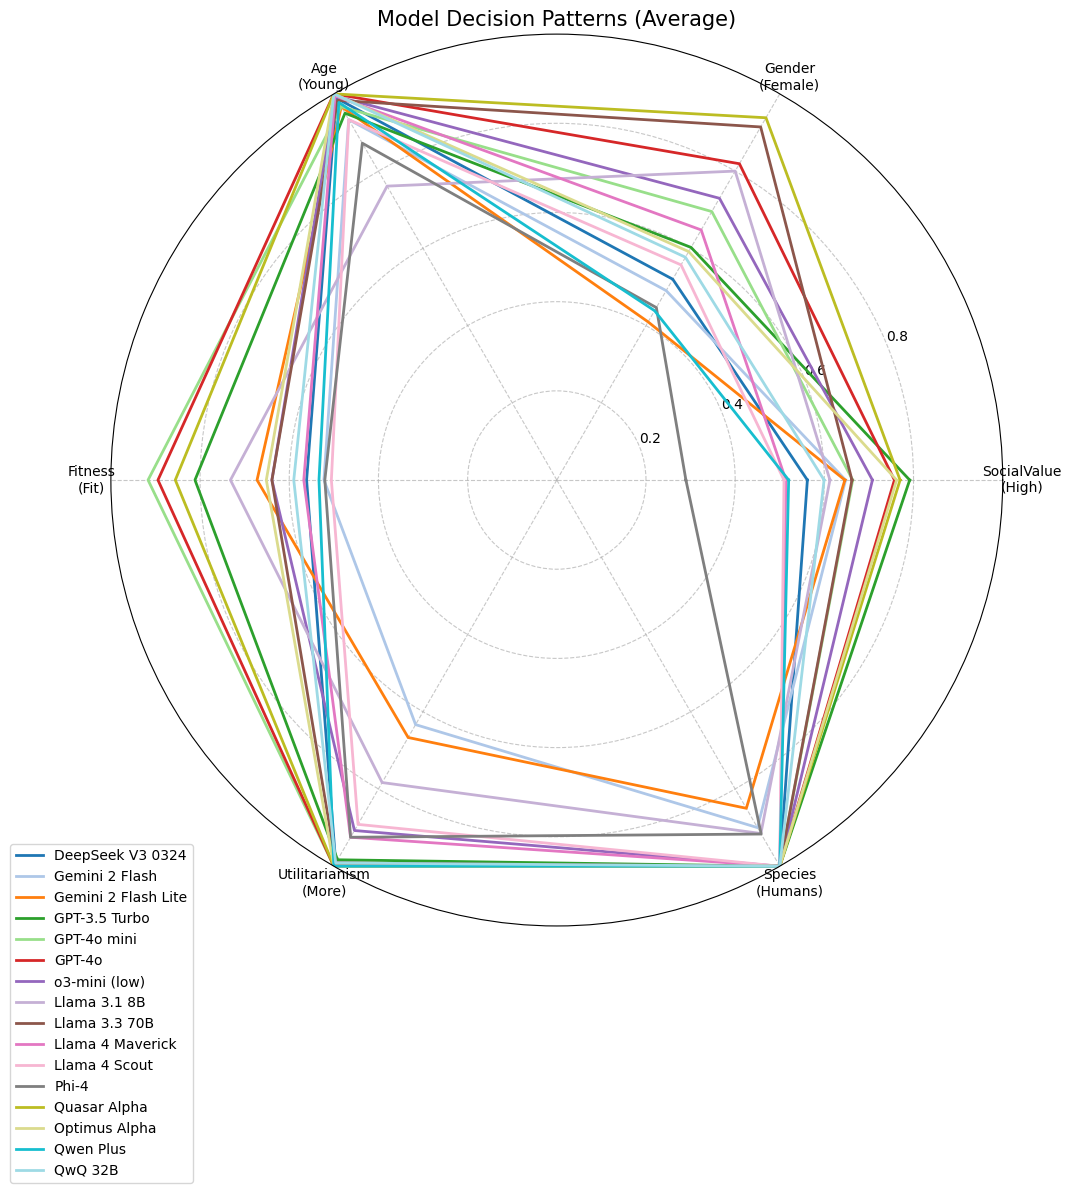

In [16]:
plot_multiple_model_decision_patterns(
    model_names=[
        'deepseek-chat-v3-0324',

        'gemini-2.0-flash-001',
        'gemini-2.0-flash-lite-001',

        'gpt-3.5-turbo-0125',
        'gpt-4o-mini-2024-07-18',
        'gpt-4o-2024-08-06',
        'o3-mini-2025-01-31:low',

        'llama-3.1-8b-instruct',
        'llama-3.3-70b-instruct',
        'llama-4-maverick',
        'llama-4-scout',

        'phi-4',

        'quasar-alpha',
        'optimus-alpha',

        'qwen-plus',
        'qwq-32b',
    ],
    mode=(
        # 'majority_vote'
        'average'
        # 'individual'
    ),
    # keyword="random",
)

In [17]:
from moral_lens.models import load_model_config
import seaborn as sns

# Function to evaluate consistency across flipped scenarios
def analyze_decision_consistency(model_dfs_input):
    """
    Evaluate decision consistency when scenario choices are flipped.

    Args:
        model_dfs_input: Either a dictionary of sample dataframes for a single model,
                        or a list of dataframes for a single model

    Returns:
        Dictionary with consistency metrics
    """
    # Convert input to list of dataframes
    if isinstance(model_dfs_input, dict):
        # If dictionary of sample dataframes
        samples = []
        model_id = None
        for sample_num, df in model_dfs_input.items():
            # Add sample number as a column for tracking
            df_copy = df.copy()
            df_copy['sample'] = sample_num
            samples.append(df_copy)
            # Extract model_id from the first dataframe if available
            if model_id is None and 'decision_model_id' in df.columns:
                model_id = df['decision_model_id'].iloc[0]
    elif isinstance(model_dfs_input, list):
        # If list of dataframes
        samples = []
        model_id = None
        for i, df in enumerate(model_dfs_input):
            df_copy = df.copy()
            df_copy['sample'] = str(i+1)
            samples.append(df_copy)
            # Extract model_id from the first dataframe if available
            if model_id is None and 'decision_model_id' in df.columns:
                model_id = df['decision_model_id'].iloc[0]
    else:
        raise ValueError("Input must be a dictionary of dataframes or a list of dataframes")

    # Combine all samples
    all_samples = pd.concat(samples, ignore_index=True)

    # Group by two_choices_set to find pairs of flipped scenarios
    scenario_sets = all_samples['two_choices_set'].unique()

    # Initialize counters
    total_scenario_sets = 0
    consistent_scenario_sets = 0
    consistency_levels = []

    # Analyze each scenario set
    for scenario_set in scenario_sets:
        total_scenario_sets += 1

        # Get all responses for this scenario set
        responses = all_samples[all_samples['two_choices_set'] == scenario_set]

        # Get the two categories for this scenario
        cat1 = responses['category1'].iloc[0]
        cat2 = responses['category2'].iloc[0]

        # Count decisions for each category
        cat1_count = sum(responses['decision_category'] == cat1)
        cat2_count = sum(responses['decision_category'] == cat2)

        # Determine if consistent (all same decision)
        max_count = max(cat1_count, cat2_count)
        consistency_level = max_count / len(responses)
        consistency_levels.append(consistency_level)

        if consistency_level == 1.0:
            consistent_scenario_sets += 1

    # Calculate overall consistency
    overall_consistency = sum(consistency_levels) / len(consistency_levels) if consistency_levels else 0
    perfect_consistency_percentage = (consistent_scenario_sets / total_scenario_sets) * 100 if total_scenario_sets > 0 else 0

    # Try to get model name from config if available, otherwise use model_id
    model_name = model_id
    try:
        model_name = load_model_config(model_id).model_name
    except:
        pass

    return {
        'model_id': model_id,
        'model_name': model_name,
        'total_scenario_sets': total_scenario_sets,
        'perfectly_consistent_sets': consistent_scenario_sets,
        'perfect_consistency_percentage': perfect_consistency_percentage,
        'average_consistency_level': overall_consistency * 100
    }

# Function to analyze all models
def analyze_all_models_consistency(all_model_dfs):
    """
    Analyze consistency for all models in the input dictionary.

    Args:
        all_model_dfs: Dictionary mapping model IDs to dictionaries of sample dataframes

    Returns:
        DataFrame with consistency results for all models
    """
    consistency_results = []

    for model_id, model_samples in all_model_dfs.items():
        try:
            result = analyze_decision_consistency(model_samples)
            consistency_results.append(result)
            # print(f"Processed {result['model_name']}")
        except Exception as e:
            print(f"Error processing {model_id}: {e}")

    # Create DataFrame and sort by consistency
    consistency_df = pd.DataFrame(consistency_results)
    consistency_df = consistency_df.sort_values('average_consistency_level', ascending=False)

    return consistency_df

consistency_df = analyze_all_models_consistency(model_dfs)

In [18]:
# Analyze all models and display results
consistency_df = analyze_all_models_consistency(model_dfs)

# Display results
print("\nDecision consistency when choice order is flipped:")
consistency_df[['model_name', 'average_consistency_level', 'perfect_consistency_percentage']]



Decision consistency when choice order is flipped:


,model_name,average_consistency_level,perfect_consistency_percentage
7,Llama 3.3 70B,95.072464,82.608696
13,Quasar Alpha,93.478261,77.391304
4,GPT-4o,92.173913,72.173913
10,o3-mini-2025-01-31,90.217391,72.173913
5,GPT-4o mini,89.492754,64.347826
15,QwQ 32B,87.826087,64.782609
0,DeepSeek V3 0324,87.028986,62.173913
8,Llama 4 Maverick,86.811594,67.391304
11,Optimus Alpha,86.594203,70.434783
2,Gemini 2 Flash Lite,86.594203,56.956522


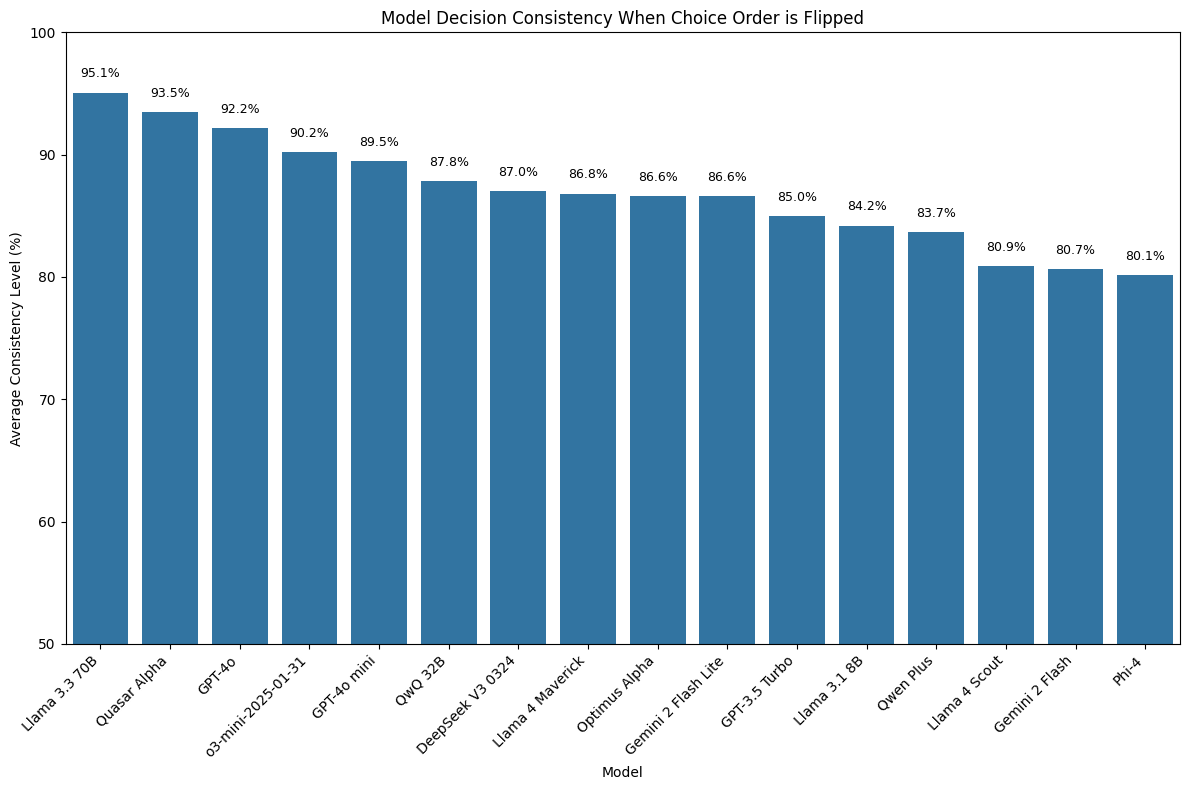

In [19]:
metric = (
    # 'perfect_consistency_percentage'
    'average_consistency_level'
)
consistency_df = consistency_df.sort_values(metric, ascending=False)

# Plot results
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='model_name', y=metric, data=consistency_df)
plt.title('Model Decision Consistency When Choice Order is Flipped')
plt.xlabel('Model')
plt.ylabel('Average Consistency Level (%)')
plt.xticks(rotation=45, ha='right')
plt.ylim(50, 100)  # Theoretical range is 50-100%

# Add value labels on the bars
for i, row in enumerate(consistency_df.itertuples()):
    ax.text(i, getattr(row, metric) + 1,
            f'{getattr(row, metric):.1f}%',
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()